# <b>Analysis of Austin Animal Center Shelter Outcome dataset</b>
Trying to model the outcomes of animals at the Austin Animal Center Shelter, using the [Austin Animal Center Shelter Income and Outcome dataset (Kaggle).](https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes) <br>

By Dar Mendelowitz

## <b>Imports</b>

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Statistics
from scipy.stats import chi2_contingency

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning library
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
import lime
import lime.lime_tabular

# Helper functions
from utils import print_animal_count, convert_to_years, replace_same_color
from utils import get_top_k, set_top_k_colors, sort_colors, set_top_k_breeds
from missing_values import print_animal_ids, count_missing_values, get_missing_animal_ids
from missing_values import get_existing_animal_ids_in_dataset, filter_null_values, update_column
from train_model import print_scores, get_scores, calculate_average_score, print_average_score
from train_model import fit_and_predict
from skip_run import print_model

import warnings
warnings.filterwarnings("ignore")

## <b>Loading the Austin Animal Center Shelter Outcome dataset</b>

In [2]:
# Loading the CSV dataset
df_in_out = pd.read_csv("./data/aac_intakes_outcomes.csv")
df_in = pd.read_csv("./data/aac_intakes.csv")
df_out = pd.read_csv("./data/aac_outcomes.csv")
dtf = df_out

# Defining the columns
cols = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'date_of_birth', 'datetime',
        'monthyear', 'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome']
dtf = dtf[cols]

In [3]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [4]:
dtf.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,80673,80681,80681,80681,80681,80681,80681,80681,56116,36893,80667,80679
unique,46,72877,5,2176,532,5956,66474,66474,14824,19,9,5
top,1 year,A721033,Dog,Domestic Shorthair Mix,Black/White,2015-09-01T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14911,13,45856,23821,8396,112,39,39,362,20082,34232,28702


In the table above, the number of animals in the shelter is 80681 (the count of unique 'animal_id' entries). However, not all columns contain 80681 values, as some entries are missing (NaN values).

For instance:

* The column 'age_upon_outcome' contains slightly fewer values, specifically 80673 entries.
* The 'name' column has significantly fewer entries, totaling 56116.
* In the 'outcome_subtype' column, there are even fewer entries, with only 36893 values present, which is less than half of the total number of animals in the shelter.
* Additionally, both the 'outcome_type' and 'sex_upon_outcome' columns have fewer entries.

Moreover, the number of unique 'animal_id' entries is less than the overall number of 'animal_id' entries (72877 < 80681). This discrepancy occurs because some animals have returned to the shelter. For example, a cat named Elsa (animal_id: A684460) was initially adopted (first outcome) at the age of 2 months. However, she was later returned to the shelter (sadly, her owner surrendered her at the age of 1 year, according to the aac_intakes_outcomes.csv table). After 25 days, Elsa was transferred to another shelter (second outcome).

***

### A first examination of the target feature - 'outcome_type':

A histogram of the target feature 'outcome_type':

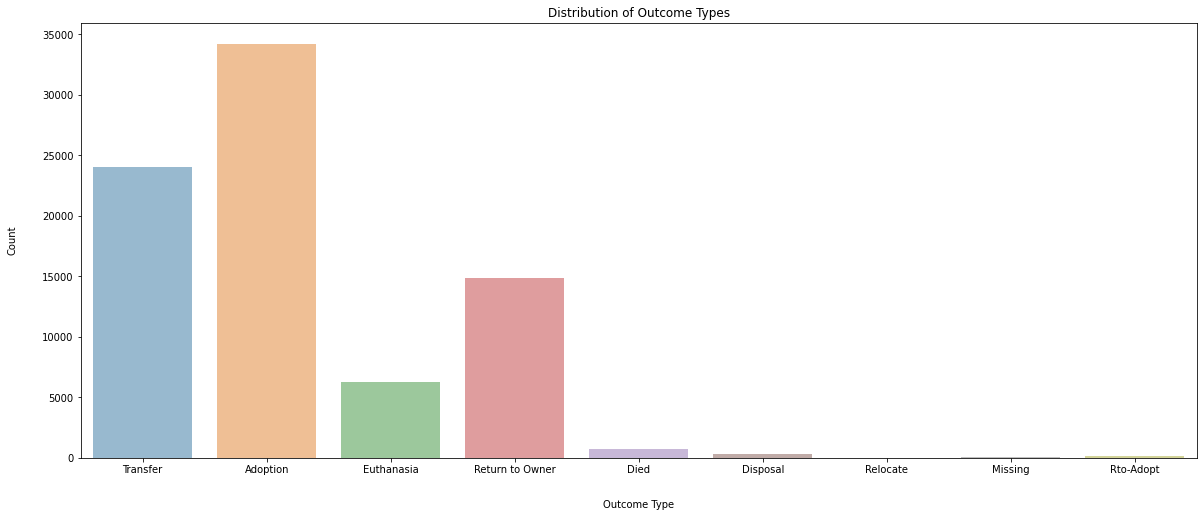

In [5]:
plt.figure(figsize=(20, 8))
sns.countplot(data=dtf, x='outcome_type', alpha=0.5)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type', labelpad=25)
plt.ylabel('Count', labelpad=25)
plt.show()

We can see that most animals were adopted (almost 35,000 animals). Almost 25,000 animals were transfered (to another shelter), about 15,000 were returned to their original owners, a little bit more than 5000 were euthanized. A small number of animals have died, an even smaller number were disposed, relocated, missing or Rto-Adopted.

Overall, most animals either were adopted, transfered, returned to owner or euthanized.

***

## <b>Data Pre-Processing</b>

***Feature engineering and data cleansing.***

### <b>Outcome Type Distribution</b>

Counting the number of outcome types:

In [6]:
print_animal_count(dtf, 'outcome_type')

      outcome_type  count  percentage
0         Adoption  34232   42.436188
8         Transfer  24050   29.813926
6  Return to Owner  14851   18.410255
3       Euthanasia   6289    7.796249
1             Died    699    0.866525
2         Disposal    304    0.376858
7        Rto-Adopt    179    0.221900
4          Missing     47    0.058264
5         Relocate     16    0.019835


According to the Austin Animal Center Shelter website, 'Rto-Adopt' is when an animal is returned to their owner <font color='#5fc7fa'>(Rto=return to owner)</font>, usually after it was lost, taken in the shelter as a stray and the shelter was able to locate a chip that led to the owner. Since there aren't a lot of samples of the 'Rto-Adopt' instance and it's the same as 'Return to Owner outcome', I've decided to combine both outcome types:

In [7]:
# Replace 'Rto-Adopt' with 'Return to Owner' in the 'outcome_type' column
dtf['outcome_type'] = dtf['outcome_type'].replace('Rto-Adopt', 'Return to Owner')

Removing all instances with less than 1% samples in the dataset - 'Died', 'Disposal', 'Missing' and 'Relocate':

In [8]:
dtf = dtf[(dtf['outcome_type'] != 'Died') & 
          (dtf['outcome_type'] != 'Disposal') & 
          (dtf['outcome_type'] != 'Missing') & 
          (dtf['outcome_type'] != 'Relocate')]

After change:

In [9]:
print_animal_count(dtf, 'outcome_type')

      outcome_type  count  percentage
0         Adoption  34232   43.004485
3         Transfer  24050   30.213188
2  Return to Owner  15030   18.881672
1       Euthanasia   6289    7.900655


The model will predict one of these four possible outcome types as the outcome of an animal listed in the dataset:

In [10]:
outcome_list = ['Return to Owner', 'Transfer', 'Adoption', 'Euthanasia']

***

### <b>Animal Type Distribution</b>

Counting the number of each animal type:

In [11]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
2         Dog  45686   57.383659
1         Cat  29577   37.150035
4       Other   4035    5.068140
0        Bird    307    0.385606
3   Livestock     10    0.012560


We can see that the two most common animals in the shelter are cats and dogs (57.38% of animals in the shelter are dogs and 37.31% are cats).
Other kind of animals (including a variety of different animals - small mammal such as bats, racoons and rabbits, wild animals such as bobcats and deers, and also reptiles and arachnids) make just 4.9% of animals in the shelter. Birds and livestock contribute less than 1%. For simplicity, I've opted to categorize birds and livestock under the 'Other' classification.

Combining birds and livestock under the 'Other' animal type classification:

In [12]:
# Replace 'Livestock' and 'Bird' with 'Other' in the 'animal_type' column
dtf['animal_type'] = dtf['animal_type'].replace(['Livestock', 'Bird'], 'Other')

Counting the number of animals:

In [13]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
1         Dog  45686   57.383659
0         Cat  29577   37.150035
2       Other   4352    5.466307


Now there are only three animal groups in the dataset - cats, dogs and other.

***

### <b>Missing values</b>

How many values are missing?

In [14]:
dtf.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23787
outcome_subtype     43368
outcome_type           14
sex_upon_outcome        2
dtype: int64

There are 8 missing values in the 'age_upon_outcome' column, 14 in the 'outcome_type' column, and 2 in the 'sex_upon_outcome' column, all of which can be addressed relatively easily (for instance, some missing data may be found in the 'in_out_df' dataset). However, the primary challenge lies in managing the extensive amount of missing data in the 'name' and 'outcome_subtype' columns.

Some missing values could potentially be recovered from the aac_intakes_outcomes.csv dataset and the aac_intakes.csv dataset. While columns such as 'age_upon_outcome', 'outcome_type', and 'sex_upon_outcome' contain only a few missing values, it is worth searching for any existing missing data that might be present in the other datasets (besides searching for missing data of the two major sparse columns - 'name' and 'outcome_subtype').

***

#### <b>Missing values of 'age_upon_outcome'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in_out</b></font> (using the aac_intakes_outcomes.csv dataset):

In [15]:
column_name = 'age_upon_outcome'
df_id = 'animal_id_outcome'

# Find all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_age)

# Selecting the existing 'animal_id' values based on existence in the filtered df_in_out
existing_animal_id_age = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                                        missing_animal_ids_age, df_id)
print_animal_ids(column_name, existing_animal_id_age, 'df_in_out')

Animal IDs with missing values in 'age_upon_outcome' column:
71248    A737705
80344    A768766
80541    A768782
80544    A769181
80548    A769209
80608    A769277
80628    A768281
80664    A769101
Name: animal_id, dtype: object

Animal IDs with missing values in 'age_upon_outcome' column that exist in df_in_out dataset:
80541    A768782
Name: animal_id, dtype: object



Retrieving the missing value, updating the dataset and removing missing values:

In [16]:
# Retrieving the missing value and updating the 'age_upon_outcome' column with the new value
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_age, df_id)

# Geting all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)

# Filtering dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_age)]

***

#### <b>Missing values of 'outcome_type'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in_out</b></font> (using the aac_intakes_outcomes.csv dataset):

In [17]:
column_name = 'outcome_type'
df_id = 'animal_id_outcome'

# Find all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_outcome)

# Selecting the existing 'animal_id' values based on existence in the filtered df_in_out
existing_animal_id_outcome = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                                            missing_animal_ids_outcome, df_id)

# Filtering out any null values
existing_animal_id_outcome = filter_null_values(df_in_out, column_name, existing_animal_id_outcome,
                                                                                    outcome_list, df_id)
print_animal_ids(column_name, existing_animal_id_outcome, 'df_in_out')

Animal IDs with missing values in 'outcome_type' column:
8056     A671017
9951     A674209
9975     A679066
12758    A686025
30969    A744013
55432    A718046
64762    A737930
67535    A755711
72899    A755715
75152    A755716
80590    A769260
80598    A769266
Name: animal_id, dtype: object

Animal IDs with missing values in 'outcome_type' column that exist in df_in_out dataset:
64762    A737930
67535    A755711
72899    A755715
75152    A755716
Name: animal_id, dtype: object



Retrieving the missing values, updating the dataset and removing missing values:

In [18]:
# Retrieving the missing values and updating the 'outcome_type' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_outcome, df_id)

# Get all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)

# Filter dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_outcome)]

***

#### <b>Missing values of 'sex_upon_outcome'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in_out</b></font> (using the aac_intakes_outcomes.csv dataset):

In [19]:
column_name = 'sex_upon_outcome'
df_id = 'animal_id_outcome'

# Find all 'animal_id' of rows with None values in the 'sex_upon_outcome' column
missing_animal_ids_outcome_sex = get_missing_animal_ids(dtf, column_name)
count_missing_values(column_name, missing_animal_ids_outcome_sex)

# Selecting the existing 'animal_id' values from missing_animal_ids_outcome_sex
# based on existence in the filtered df_in_out
existing_animal_id_outcome_sex = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                                        missing_animal_ids_outcome_sex, df_id)
count_missing_values(column_name, existing_animal_id_outcome_sex, 'df_in_out')

Number of animal IDs with missing values in 'sex_upon_outcome' column is 1.
Number of animal IDs with missing values in 'sex_upon_outcome' column that exist in df_in_out dataset is 0.



There is no existing data in df_in_out dataset (that matches the missing value in the 'sex_upon_outcome' column). The missing row will just be removed from the dtf dataset:

In [20]:
# Finding the 'animal_id' that doesn't exist in df_in_out
missing_animal_id_outcome_sex = missing_animal_ids_outcome_sex.iloc[0]

# Filter dtf to exclude the row with the 'animal_id' value of missing_animal_id_outcome_sex
dtf = dtf.drop(dtf[dtf['animal_id'] == missing_animal_id_outcome_sex].index)

***

#### <b>Missing values of 'outcome_subtype'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in_out</b></font> (using the aac_intakes_outcomes.csv dataset):

In [21]:
column_name = 'outcome_subtype'
df_id = 'animal_id_outcome'

sub_outcome_list = dtf['outcome_subtype'].dropna().unique()

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)
count_missing_values(column_name, missing_animal_ids_sub)

# Selecting the existing 'animal_id' values based on existence in the filtered df_in_out
existing_animal_id_sub = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                                            missing_animal_ids_sub, df_id)

# Filtering out any null values
existing_animal_id_sub = filter_null_values(df_in_out, column_name, existing_animal_id_sub,
                                                                        sub_outcome_list, df_id)
count_missing_values(column_name, existing_animal_id_sub, 'df_in_out')

Number of animal IDs with missing values in 'outcome_subtype' column is 43357.
Number of animal IDs with missing values in 'outcome_subtype' column that exist in df_in_out dataset is 1833.



<br>The count of animal IDs with missing values in the 'outcome_subtype' column is 43,357. Among these, 1,833 IDs also exist in the 'df_in_out' dataset, indicating a smaller yet notable subset.

Retrieving the missing values and updating the dataset, while defining a default outcome subtype for missing values:

In [22]:
# Retrieving the missing values and updating the 'outcome_subtype' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_sub, df_id)

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)

# Define a default value for missing values in 'outcome_subtype' column
default_subtype = "Unknown"

# Set the default value for 'outcome_subtype' where 'animal_id' matches any element in missing_animal_ids_sub
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_sub), column_name] = default_subtype

I refrained from simply duplicating the values from the 'outcome_type' column and substituting them with missing values in the 'outcome_subtype' column, respectively. My rationale behind this decision was to avoid <b>artificially inflating</b> the importance of those instances. By replicating the same value twice within a single row for certain entries in the dataset, it could potentially <b>skew</b> the significance of those instances compared to others. I opted to assign a default value of 'Unknown' instead.

***

#### <b>Missing values of 'name'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in</b></font> (using the aac_intakes.csv dataset):

In [23]:
column_name = 'name'
df_id = 'animal_id'

# Find all 'animal_id' of rows with None values in the 'name' column
missing_animal_ids_name = get_missing_animal_ids(dtf, column_name)
count_missing_values(column_name, missing_animal_ids_name)

# Selecting the existing 'animal_id' values based on existence in the filtered df_in
existing_animal_id_name = get_existing_animal_ids_in_dataset(df_in, column_name,
                                                        missing_animal_ids_name, df_id)
count_missing_values(column_name, existing_animal_id_name, 'df_in')

Number of animal IDs with missing values in 'name' column is 23775.
Number of animal IDs with missing values in 'name' column that exist in df_in dataset is 0.



There is no existing data in df_in dataset (that matches the missing values in the 'name' column).

Animals without a name will be given a default name. The reason that I chose to give them a default name (rather than just deleting the rows with the missing values) is that there might be a <b>reason</b> why these animals weren't given a name, and the fact that they don't have a name <b>might predict</b> their outcome. For example, rabid animals that are being euthanized aren't being named.

<b>Missing values in the <font color='#fc0335'>df_in</font> dataset:</b>

In [24]:
df_in['name'].isnull().sum()

24584

We can see that the number of missing names in the df_in dataset is similar to the number of missing names in the dtf dataset:
<br>24584 in df_in vs. 24553/23775 in dtf before/after eliminating instances in the 'outcome_type'/'outcome_subtype' columns.

Perhaps Some of the animals were just taken in the shelter and nothing changed since that, so they don't have any outcome recorded, and therefore don't appear in the outcome dataset dtf, which can explains the difference in the numbers.
<br>

Some animals in the shelter have a name, and some don't. The name itself might not predict the outcome of the animal, but the fact that the animal has a name does. For this reason I've decided to convert the 'name' column to a 'binary' column ('Yes' or 'No') if an animal has a name or if it doesn't:

In [25]:
# Rename the column 'name' to 'is_named'
dtf.rename(columns={'name': 'is_named'}, inplace=True)

# Define a default value for the 'is_named' column (that will be replaced)
default_name = "Unknown"

# Set the default value for 'is_named' where 'animal_id' matches any element in missing_animal_ids_name
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_name), 'is_named'] = default_name

dtf['is_named'] = np.where(dtf['is_named'].str.contains('Unknown'), 'No', 'Yes')

***

#### Missing values - Conclusion:

How many values are missing now?

In [26]:
dtf.isnull().sum()

age_upon_outcome    0
animal_id           0
animal_type         0
breed               0
color               0
date_of_birth       0
datetime            0
monthyear           0
is_named            0
outcome_subtype     0
outcome_type        0
sex_upon_outcome    0
dtype: int64

Now there are no missing values in the dataset.

***

### <b>Additional Feature Engineering</b>

#### <b>Changing representation of values in 'age_upon_outcome' column:</b>

In [27]:
# Converting the values in the 'age_upon_outcome' column into numeric values representing years
dtf['age_upon_outcome'] = dtf['age_upon_outcome'].apply(convert_to_years)

Relation between the target feature 'outcome_type' and the feature 'age_upon_outcome':

In [28]:
# One-hot encode the 'outcome_type' column
dtf_encoded = pd.get_dummies(dtf, columns=['outcome_type', 'animal_type'], prefix=['outcome_type', 'animal_type'])

# Compute the correlation matrix with respect to 'age_upon_outcome'
dtf_corr_age = dtf_encoded.corr(method="pearson")

outcome_type_columns = [col for col in dtf_encoded.columns if 'outcome_type' in col]

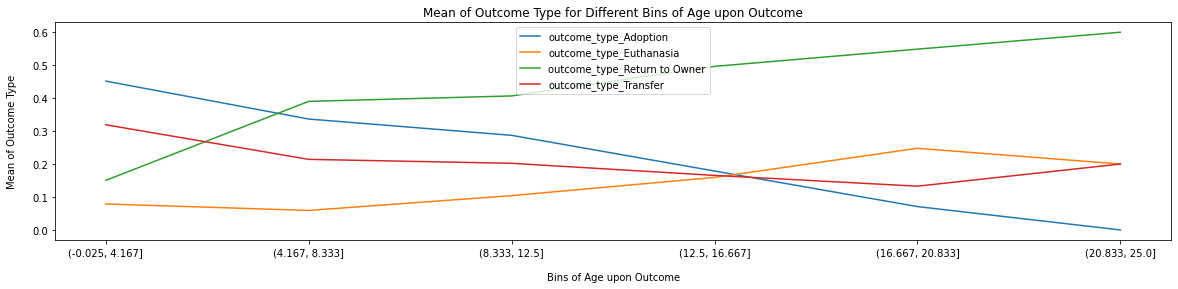

In [29]:
# Create bins for 'age_upon_outcome'
bins = pd.cut(dtf_encoded['age_upon_outcome'], 6)

# Group by bins and calculate the mean for each group for 'outcome_type_columns'
grouped_means = dtf_encoded.groupby(bins)[outcome_type_columns].mean()

# Plot the line plot
fig, ax = plt.subplots(figsize=(20, 4))
ax.set_facecolor('w')
grouped_means.plot(kind='line', ax=ax)

# Adjust labels and title as needed
ax.set_xlabel('Bins of Age upon Outcome', labelpad=15)
ax.set_ylabel('Mean of Outcome Type', labelpad=15)
ax.set_title('Mean of Outcome Type for Different Bins of Age upon Outcome')

plt.show()

The x-axis is represented by bins, each bin is a range of ages of animals in the shelter (note that -0.025 doesn't represent an actual age. Since all the graphs start from the age of 0, and not from -0.025, then there's no problem).

We can see that:
* Younger animals are more likely to get adopted, while older animal don't, as indicated by the blue graph. For instance, animals aged 0-4 years have a higher chance to get adopted (mean of outcome_type_Adoption is approximately 0.45), while older animals, ranging from 16 to 20 years, have a substantially lower adoption rate (mean of outcome_type_Adoption is approximately 0.1).
* The orange graph illustrates that younger animals face a lower likelihood of euthanasia compared to older animals.
* The green graph illustrates that younger animals are less likely to be returned to owners compared to older animals.
* The red graph illustrates that younger animals are less likely to get transfered to a partnering shelter compared to older animals, and that the age group of 16-20 is the most likely to get transfered out of all age groups.

Changing 'age_upon_outcome' into a column of ranges of ages 'age_range':

In [30]:
# Define the bins and labels
bins = [0, 4, 8, 12, 16, 20, 25]
labels = ['[0-4)', '[4-8)', '[8-12)', '[12-16)', '[16-20)', '[20-25)']

# # 0 for [0-4) age group, 1 for [4-8), 2 for [8-12), 3 for [12-16), 4 for [16-20), 5 for [20-25)
# labels = [0, 1, 2, 3, 4, 5]

# Create the 'age_range' column
dtf['age_range'] = pd.cut(dtf['age_upon_outcome'], bins=bins, labels=labels, right=False)

# Rearranging the columns in dtf
column_order = ['age_range', 'animal_id', 'animal_type', 'breed', 'color', 'date_of_birth',
                'datetime', 'monthyear', 'is_named', 'outcome_subtype', 'outcome_type',
                'sex_upon_outcome']
dtf = dtf[column_order]

***

#### <b>Deleting 'date_of_birth' column:</b>

Each animal's age is provided in the dataset. Given the variability in the accuracy of birth dates, as indicated by the Austin Animal Center Shelter website, it's more practical to represent an animal's age in a numeric format rather than relying on a datetime format to denote the day of birth. This approach accommodates instances where birth dates are uncertain or assessed, ensuring greater consistency and convenience for analysis.

In [31]:
# Removing 'date_of_birth' column from dtf
dtf = dtf.drop('date_of_birth', axis=1)

***

#### <b>Deleteing 'monthyear' column:</b>

In [32]:
datetime = dtf['datetime']
monthyear = dtf['monthyear']

# Check if the two columns are equal
are_equal = (datetime == monthyear).all()

# Print the result
if are_equal:
    print("The columns 'datetime' and 'monthyear' are equal")
else:
    print("Not equal")

The columns 'datetime' and 'monthyear' are equal


Since 'datetime' and 'monthyear' are two equal columns, I've decided to delete one of them - 'monthyear':

In [33]:
# Remove column 'monthyear'
dtf = dtf.drop('monthyear', axis=1)

***

#### <b>Converting 'datatime' column into numeric columns:</b>

Replacing the column 'datetime' into five columns - 'outcome_year' (year of outcome), 'outcome_month' (month of outcome) 'outcome_date' (day in the month of outcome), 'outcome_weekday' (day in the week of outcome),  and 'outcome_hour' (hour of outcome):

In [34]:
# Converting 'outcome_date' into datetime
dtf['datetime'] = pd.to_datetime(dtf['datetime'])

dtf['outcome_year'] = dtf['datetime'].dt.year
dtf['outcome_month'] = dtf['datetime'].dt.month
dtf['outcome_date'] = dtf['datetime'].dt.daysinmonth
dtf['outcome_weekday'] = dtf['datetime'].dt.dayofweek
dtf['outcome_hour'] = dtf['datetime'].dt.hour

# Rearranging the columns in dtf
column_order = ['age_range', 'animal_id', 'animal_type', 'breed', 'color', 'outcome_year',
                'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named',
                'outcome_subtype', 'outcome_type', 'sex_upon_outcome']
dtf = dtf[column_order]

***

#### <b>Spliting 'sex_upon_outcome' column:</b>

<font color='#839fd4'>For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).</font>

Transforming the column 'sex_upon_outcome' into two columns - 'sex' (containing the sex of the animal) and 'spayed_neutered' (containing if an animal is spayed/neutered):

In [35]:
# Create a new column 'sex' based on the 'sex_upon_outcome' column
dtf['sex'] = np.where(dtf['sex_upon_outcome'].str.contains('Male'), 'Male', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Female'))

# Create a new column 'Spay/Neuter' based on the 'sex_upon_outcome' column
dtf['spayed_neutered'] = np.where(dtf['sex_upon_outcome'].str.contains('Intact'), 'No', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Yes'))

# Deleting the 'sex_upon_outcome' column
dtf = dtf.drop(columns=['sex_upon_outcome'])

In the 'sex' column:<br>
'Male' assigned as 'Male', 'Female' assigned as 'Female', and 'Unknown' assigned as 'Unknown'.

In the 'spayed_neutered' column:<br>
'Intact' assigned as 'No', 'Spay/Neuter' assigned as 'Yes', and 'Unknown' assigned as 'Unknown'.

***

#### <b>Fixing 'color' column:</b>

'Orange' cats are gingers, and all ginger cats are tabbies. This is why I'm changing all values of 'Orange Tabby' or 'Orange' into 'Ginger':

In [36]:
# Filtering rows where 'animal_type' is 'Cat' and 'color' contains 'Orange'
cats = dtf[dtf['animal_type'] == 'Cat']
orange_cats = cats[cats['color'].str.contains('Orange')]

# Replacing 'Orange Tabby' or 'Orange' with 'Ginger' in the 'color' column
orange_cats['color'] = orange_cats['color'].str.replace('Orange Tabby', 'Ginger')
orange_cats['color'] = orange_cats['color'].str.replace('Orange', 'Ginger')

# Updating the changes in the original DataFrame
dtf.update(orange_cats)

Replacing every value in the 'color' column that contains a string separated by '/', and both parts of the string are the same (for example, 'Black/Black' will be replaced with 'Black'):

In [37]:
# Appling the function replace_same_color to the 'color' column
dtf['color'] = dtf['color'].apply(replace_same_color)

***

In [124]:
df = dtf.copy()

In [125]:
# Hyper Parameters
color_counts = [50, 50, 50]
breed_counts = [50, 300, 50]

***

#### <b>Color Distribution</b>

In [126]:
print(f"Number of different colors in the 'color' column: {len(df['color'].value_counts())}")

Number of different colors in the 'color' column: 508


The 'color' column contains 508 unique values, which could potentially make the model overly complex due to the large number of parameters. To mitigate this complexity, I'll aim to include only the most prevalent values from the column, thereby simplifying the model.

In [127]:
k = 10

Top 10 cat colors:

In [128]:
top_k_cat_colors = pd.DataFrame(get_top_k(df, 'color', 'Cat', k))
top_k_cat_colors.head(k)

,count,percentage
Brown Tabby,4467,15.104484
Black,3910,13.221073
Black/White,2793,9.444106
Brown Tabby/White,2353,7.956313
Ginger,2254,7.621559
Tortie,1362,4.605397
Calico,1328,4.490431
Ginger/White,1182,3.996754
Blue Tabby,1138,3.847975
Blue,1058,3.577467


The predominant colors of cats typically include brown tabby, black, black and white, brown and white tabby, or ginger. Keeping all instances of the top k colors, while any other color will be substituted with a default value:

In [129]:
df = set_top_k_colors(df, 'Cat', 'Other Cat Color', color_counts[0])

Top 10 dog colors:

In [130]:
top_k_dog_colors = pd.DataFrame(get_top_k(df, 'color', 'Dog', k))
top_k_dog_colors.head(k)

,count,percentage
Black/White,5253,11.499310
Black,2585,5.658808
Brown/White,2496,5.463978
Tan/White,2462,5.389549
White,2428,5.315120
Tan,2046,4.478886
Tricolor,1979,4.332217
Brown,1868,4.089227
Black/Tan,1861,4.073904
White/Black,1569,3.434688


The most common colors for dogs often include black and white, black, brown and white, tan and white, or white. Keeping all instances of the top k colors, while any other color will be substituted with a default value:

In [131]:
df = set_top_k_colors(df, 'Dog', 'Other Dog Color', color_counts[1])

Top 10 colors of other animals:

In [132]:
top_k_other_colors = pd.DataFrame(get_top_k(df, 'color', 'Other', k))
top_k_other_colors.head(k)

,count,percentage
Brown,1556,35.827769
Brown/Black,280,6.447156
Black,280,6.447156
Black/White,262,6.032696
Gray/Black,255,5.871517
Gray,246,5.664287
Black/Gray,155,3.568962
Black/Brown,151,3.476859
Red,137,3.154501
White,119,2.740041


The predominant colors for other animals typically include brown, black, brown and black, black and white or gray and black. Keeping all instances of the top k colors, while any other color will be substituted with a default value:

In [133]:
df = set_top_k_colors(df, 'Other', 'Other Color', color_counts[2])

Counting the number of unique colors:

In [134]:
print(f"Number of different colors in the 'color' column: {len(df['color'].value_counts())}")

Number of different colors in the 'color' column: 110


The 'color' column now contains only 111 unique values, down from 508. This reduction is substantial and could potentially enhance the model's performance.

***

#### <b>Spliting 'color' column:</b>

In [135]:
# Split values in the 'color' column based on '/'
split_colors = df['color'].str.split('/', expand=True)

# Apply the sorting function along the rows
# A value of two colors will be split into two values and then sorted alphabetically
sorted_colors = split_colors.apply(sort_colors, axis=1)

# Assign the first and second element to 'color1' and 'color2' respectively
df['color1'] = sorted_colors.apply(lambda x: x[0])
df['color2'] = sorted_colors.apply(lambda x: x[1])

# Replace missing values in 'color2' with a default value
default_color = 'No Color'
df['color2'].fillna(default_color, inplace=True)

In [136]:
# Drop the original 'color' column if needed
df.drop(columns=['color'], inplace=True)

# Rearrange the columns
column_order = ['age_range', 'animal_id', 'animal_type', 'breed', 'color1', 'color2',
                'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour',
                'is_named', 'outcome_subtype', 'outcome_type', 'sex', 'spayed_neutered']
df = df[column_order]

In [137]:
print(f"Number of different colors in the 'color1' column: {len(df['color1'].value_counts())}")
print(f"Number of different colors in the 'color2' column: {len(df['color2'].value_counts())}")

Number of different colors in the 'color1' column: 44
Number of different colors in the 'color2' column: 15


***

#### <b>Fixing 'breed' column:</b>

<font color='#839fd4'>For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).</font>

Adding a new column 'mixed_breed' (to identify if an animal is mixed breed or not) and correcting some breeds:

In [138]:
# Create a new column 'mixed_breed' based on the 'breed' column
df['mixed_breed'] = np.where(df['breed'].str.contains('Mix'), 'Yes', 'No')

# Rearrange the columns
column_order = ['age_range', 'animal_id', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2',
                'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named',
                'outcome_subtype', 'outcome_type', 'sex', 'spayed_neutered']
df = df[column_order]

# Removing the word 'Mix' from the breeds and removing blank spaces
df['breed'] = df['breed'].str.replace('Mix', '').str.strip()

# Replacing 'Medium Hair' with 'Mediumhair'
df['breed'] = df['breed'].str.replace('Medium Hair', 'Mediumhair')

# Replacing 'Chihuahua Shorthair' and 'Chihuahua Longhair' with 'Chihuahua'
df['breed'].replace({'Chihuahua Shorthair': 'Chihuahua', 'Chihuahua Longhair': 'Chihuahua'}, inplace=True)

# Replace breeds associated with rodents with 'Rodent' in the 'breed' column
rodents = ['Guinea Pig', 'Squirrel', 'Rat', 'Hamster']
df['breed'].replace(rodents, 'Rodent', inplace=True)

# Replacing 'Rabbit Sh' and 'Rabbit Lh' with 'Rabbit'
df['breed'].replace({'Rabbit Sh': 'Rabbit', 'Rabbit Lh': 'Rabbit'}, inplace=True)

In the 'sex' column:<br>
'Mix' assigned as 'Yes', otherwise assigned as 'No'.

In the 'breed' column:<br>
The word 'Mix' was removed from all the different breeds (irrelevant to the type of the breed). Also, 'Medium Hair' was replaceed with a single word of 'Mediumhair' (just like 'Shorthair' and 'Longhair' are single words). 'Chihuahua Shorthair' and 'Chihuahua Longhair' were replaced with 'Chihuahua'. Any kind of common rodent was replaced with the value of 'Rodent'. 'Rabbit Sh' and 'Rabbit Lh' were replaced with 'Rabbit'.

***

#### <b>Breed Distribution</b>

In [139]:
print(f"Number of different breeds in the 'breed' column: {len(df['breed'].value_counts())}")

Number of different breeds in the 'breed' column: 1949


The 'breed' column contains 1949 unique values, which could potentially make the model overly complex due to the large number of parameters. To mitigate this complexity, I'll aim to include only the most prevalent values from the column, thereby simplifying the model.

In [140]:
k = 10

Top 10 cat breeds:

In [141]:
top_k_cat_breeds = pd.DataFrame(get_top_k(df, 'breed', 'Cat', k))
top_k_cat_breeds.head(k)

,count,percentage
Domestic Shorthair,23853,80.655305
Domestic Mediumhair,2462,8.324880
Domestic Longhair,1282,4.334889
Siamese,1053,3.560560
American Shorthair,208,0.703320
Snowshoe,156,0.527490
Maine Coon,119,0.402380
Manx,80,0.270508
Russian Blue,71,0.240076
Himalayan,39,0.131873


Most cats are domestic shorthairs, domestic mediumhairs, domestic longhairs or siameses. I've decided to keep all instances of the top k breeds, while any other breed will be substituted with a default value:

--------------------Other types of cat breeds are less than 1%, and so I've decided to keep all instances that have more than 1% samples in the dataset as-is, and any other breed will be replaced with a default value:

In [142]:
df = set_top_k_breeds(df, 'Cat', 'Other Cat Breed', breed_counts[0])

Top 10 dog breeds:

In [143]:
top_k_dog_breeds = pd.DataFrame(get_top_k(df, 'breed', 'Dog', k))
top_k_dog_breeds.head(k)

,count,percentage
Pit Bull,6572,14.386725
Chihuahua,5434,11.895536
Labrador Retriever,5071,11.100895
German Shepherd,2195,4.805061
Australian Cattle Dog,1193,2.611589
Dachshund,916,2.005210
Boxer,784,1.716250
Miniature Poodle,716,1.567391
Border Collie,712,1.558635
Siberian Husky,559,1.223704


Most dogs are pit bulls, labradors, chihuahuas, german shepherds and australian cattle dogs. Keeping all instances of the top k breeds, while any other breed will be substituted with a default value:

In [144]:
df = set_top_k_breeds(df, 'Dog', 'Other Dog Breed', breed_counts[1])

Top 10 breeds of other animals:

In [145]:
top_k_other_breeds = pd.DataFrame(get_top_k(df, 'breed', 'Other', k))
top_k_other_breeds.head(k)

,count,percentage
Bat,1934,44.531430
Raccoon,660,15.196869
Rodent,356,8.197099
Rabbit,318,7.322128
Opossum,262,6.032696
Chicken,122,2.809118
Skunk,116,2.670965
Fox,58,1.335482
Californian,34,0.782869
Ferret,32,0.736818


Most of the other animals are bats, raccoons, rabbits, opoussums and guinea pigs. Keeping all instances of the top k breeds, while any other breed will be substituted with a default value:

----------------------Other types of breeds are less than 150 samples, and so I've decided to keep all instances that have above than 150 samples in the dataset as-is, and any other breed will be replaced with a default value:

In [146]:
df = set_top_k_breeds(df, 'Other', 'Other Breed', breed_counts[2])

Counting the number of unique colors:

In [147]:
print(f"Number of different breeds in the 'breed' column: {len(df['breed'].value_counts())}")

Number of different breeds in the 'breed' column: 403


The 'breed' column now contains only 403 unique values, down from 1949. This reduction is substantial and could potentially enhance the model's performance.

***

## <b>Goodness Of Fit</b>

### <b>Chi-Squared Test for Feature Selection</b>

In [148]:
# Columns for analysis
columns_of_interest = ['age_range', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2',
                    'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour',
                    'is_named', 'outcome_subtype', 'sex', 'spayed_neutered']

In [149]:
# Create a list to store the results
chi_results = []

# Loop through each column and perform chi-square test
for column in columns_of_interest:
    contingency_table = pd.crosstab(df[column], df['outcome_type'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi_results.append({'column' : column, 'score' : chi2, 'p_val' : p})

In [150]:
chi_df = pd.DataFrame(chi_results).sort_values('p_val', ascending=False)
chi_df.head(15)

,column,score,p_val
8,outcome_date,234.936639,1.500573e-45
6,outcome_year,751.885872,1.598715e-150
3,mixed_breed,1018.138709,2.090538e-220
0,age_range,5876.125949,0.000000e+00
1,animal_type,38172.677607,0.000000e+00
2,breed,51165.052797,0.000000e+00
4,color1,10106.812162,0.000000e+00
5,color2,5864.412669,0.000000e+00
7,outcome_month,1807.295572,0.000000e+00
9,outcome_weekday,2617.061543,0.000000e+00


It looks like all of the columns have extremely low p-values, indicating that there is strong evidence to reject the null hypothesis that there is no association between each of these columns and the outcome_type. In other words, the values in each column are not distributed randomly across different outcome types; instead, they are related to or influenced by the outcome type of the animal. This association indicates that each column contains information that can help predict or explain the outcome type of animal outcomes in the dataset. Therefore, these columns are potentially important predictors or factors influencing the outcome type.

***

### <b>Examining Correlations to the target feature</b>

In [151]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'age_range', 'animal_type', 'mixed_breed', 'is_named', 'sex',
                    'spayed_neutered']

# Encoding columns using one-hot encoding
dtf_encoded = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns
outcome_type_columns = [col for col in dtf_encoded.columns if 'outcome_type' in col]

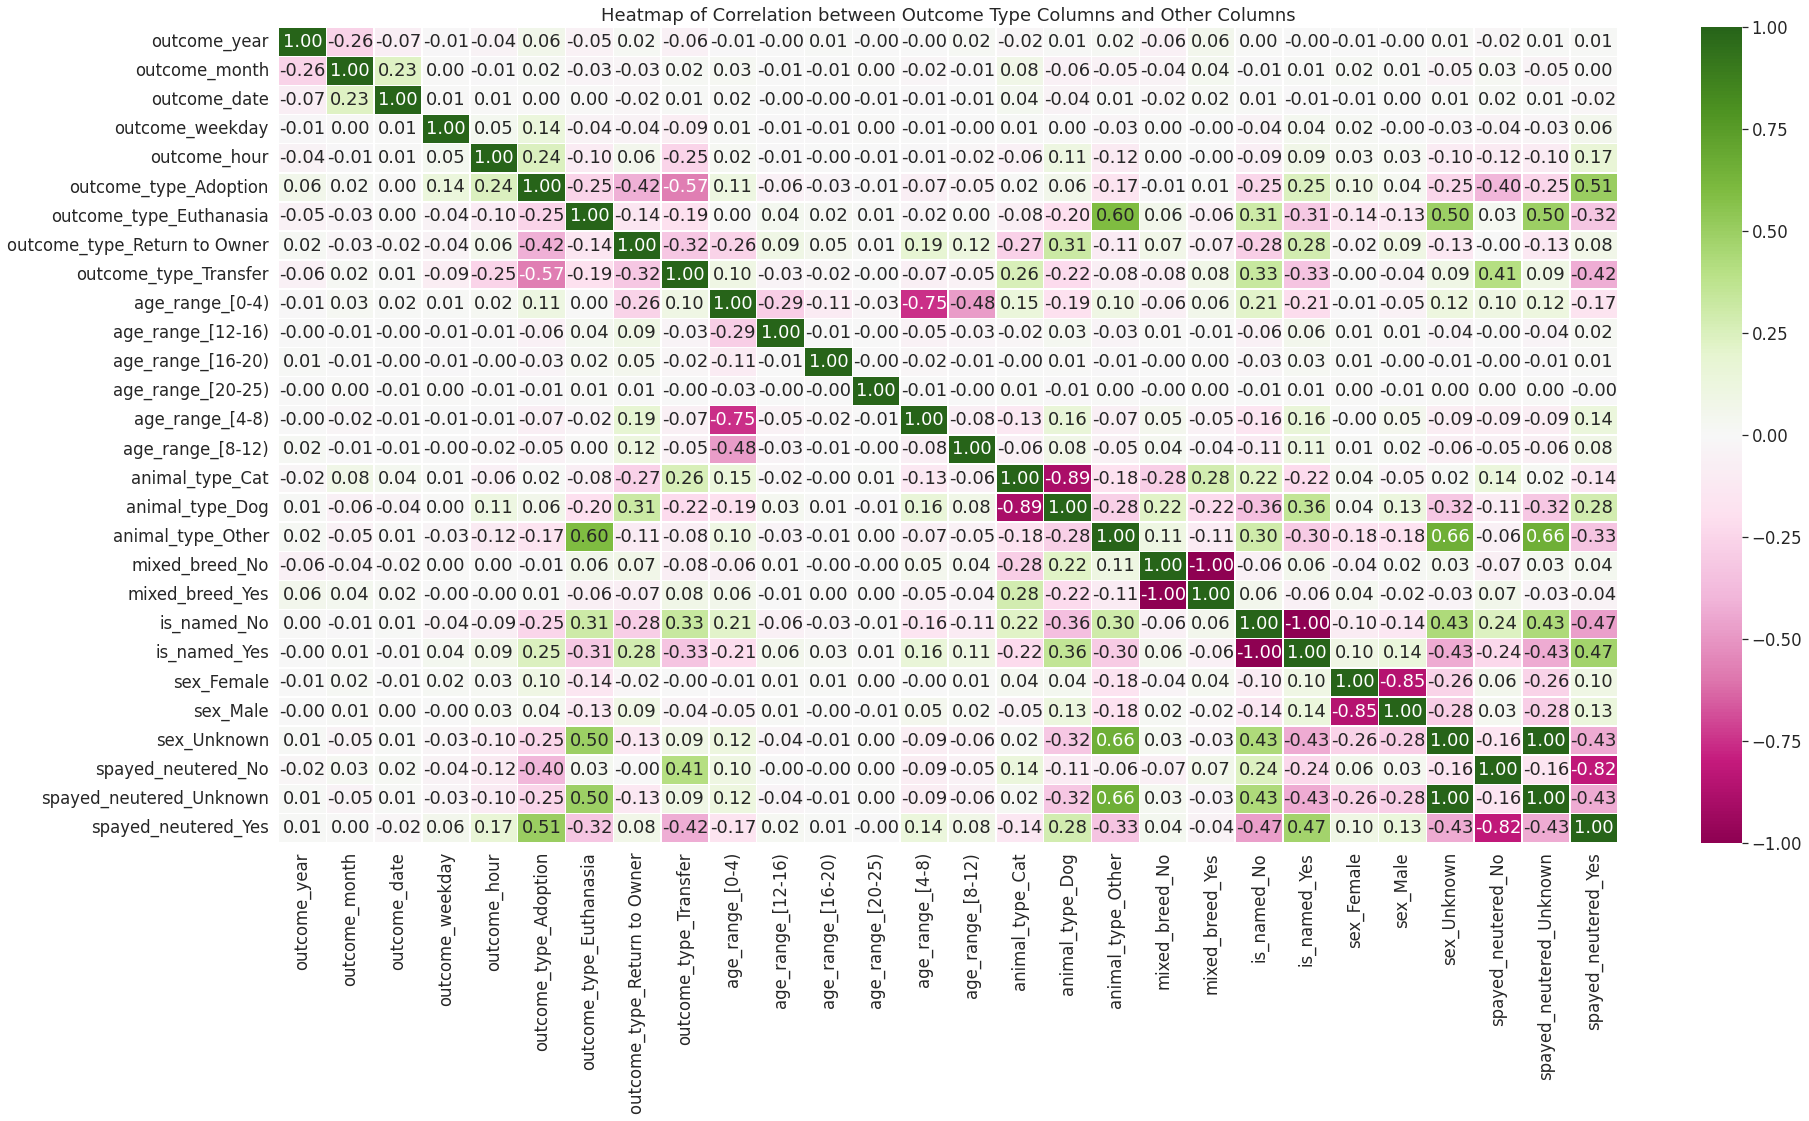

In [156]:
# Computing the correlation matrix
dtf_corr = dtf_encoded.corr(method="pearson")

# Plotting the heatmap
plt.subplots(figsize=(20,15))
sns.heatmap(dtf_corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap="PiYG", cbar=True, linewidths=0.5)
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.show()

We can see that columns like <font color='#012f85'><b>'outcome_date'</b></font>, <font color='#012f85'><b>'outcome_month'</b></font> and <font color='#012f85'><b>'outcome_year'</b></font> have little impact on the target features (<font color='#089ffc'><b>'outcome_type_Adoption/Euthanasia/Return to Owner/Transfer'</b></font>), and may not add new insights predicting it. They do have some correlations with each other though (respectively). For instance, there is a correlation of -0.26 between 'outcome_year' and 'outcome_month' (which does makes sense).

Also, features <font color='#012f85'><b>'mixed_breed_No'</b></font> and <font color='#012f85'><b>'mixed_breed_Yes'</b></font> may have a correlation of <font color='#de0492'><b>-1.00</b></font>, which make them highly correlated, and they do have some correlation with <font color='#012f85'><b>'animal_type_Cat'</b></font> and <font color='#012f85'><b>'animal_type_Dog'</b></font> (correlation of <font color='#de0492'><b>-0.28</b></font>/<font color='#015714'><b>0.28</b></font> with <font color='#012f85'><b>'animal_type_Cat'</b></font> and correlation of <font color='#015714'><b>0.23</b></font>/<font color='#de0492'><b>-0.23</b></font> with <font color='#012f85'><b>'animal_type_Dog'</b></font>, both respectively), but they have little impact on the target features (<font color='#089ffc'><b>'outcome_type_Adoption/Euthanasia/Return to Owner/Transfer'</b></font>), and may not add new insights predicting it.

-----------------add more comments.

#### <b>Comparing to 'outcome_subtype' column:</b>

In [153]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'outcome_subtype']

# Encoding columns using one-hot encoding
dtf_encoded_outcome = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns and outcome subtype columns
outcome_type_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_type' in col]
outcome_subtype_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_subtype' in col]

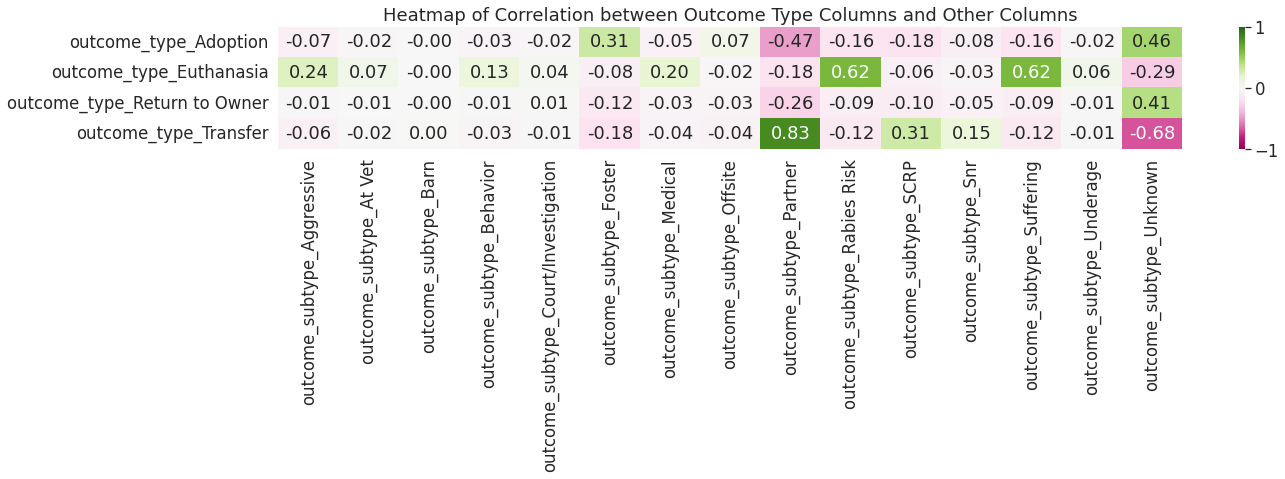

In [154]:
# Computing the correlation matrix
dtf_corr = dtf_encoded_outcome[outcome_type_columns + outcome_subtype_columns].corr(method="pearson")

# Plotting the heatmap
plt.subplots(figsize=(20, 7))
sns.heatmap(dtf_corr.loc[outcome_type_columns, outcome_subtype_columns], vmin=-1, vmax=1, annot=True,
        cmap='PiYG', fmt=".2f")
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.tight_layout()
plt.show()

There is a strong association between <font color='#012f85'><b>'outcome_subtype_Partner'</b></font> and <font color='#089ffc'><b>'outcome_type_Transfer'</b></font>, evidenced by a correlation coefficient of <font color='#015714'><b>0.83</b></font>. This suggests that many instances with the outcome type of transfer, predominantly involving cats, have an outcome subtype of partner, indicating a transfer to a partnering shelter. Also, animals associated with <font color='#012f85'><b>'outcome_subtype_Partner'</b></font> are less likely to get adopted, as indicated by a correlation of <font color='#de0492'><b>-0.47</b></font> with <font color='#089ffc'><b>'outcome_type_Adoption'</b></font>.

Additionally, animals identified with <font color='#012f85'><b>'outcome_subtype_Rabies Risk'</b></font> or <font color='#012f85'><b>'outcome_subtype_Suffering'</b></font> demonstrate a higher likelihood of euthanasia, with correlation coefficients of <font color='#015714'><b>0.62</b></font> and <font color='#015714'><b>0.62</b></font>, respectively, with <font color='#089ffc'><b>'outcome_type_Euthanasia'</b></font>.

Moreover, animals categorized with <font color='#012f85'><b>'outcome_subtype_Unknown'</b></font> are less inclined to be transferred (correlation of <font color='#de0492'><b>-0.68</b></font> with <font color='#089ffc'><b>'outcome_type_Transfer'</b></font>) or euthanized (correlation of <font color='#de0492'><b>-0.29</b></font> with <font color='#089ffc'><b>'outcome_type_Euthanasia'</b></font>). Instead, they show potential for being returned to their owners (correlation of <font color='#015714'><b>0.41</b></font> with <font color='#089ffc'><b>'outcome_type_Return to Owner'</b></font>) or adopted (correlation of <font color='#015714'><b>0.46</b></font> with <font color='#089ffc'><b>'outcome_type_Adoption'</b></font>).

***

## <b>Basic ML Model</b>

### <b>Training the model and predicting</b>

In [157]:
# List of columns to convert
columns_to_convert = ['outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour',]

# Convert each column from float64 to int64
for column in columns_to_convert:
    df[column] = df[column].astype('int64')

# Convert column values to strings
df['age_range'] = df['age_range'].astype(str)

# Remove characters from column names
df['age_range'] = df['age_range'].str.replace('[', '').str.replace(']', '').str.replace('<', '').str.replace(')', '')

# Dropping 'animal_id' column from the dataframe
dtf_model = df.drop('animal_id', axis=1)

# Converting all columns to the category data type
dtf_model = dtf_model.astype('category')

In [158]:
# Columns for one-hot encoding
columns_for_one_hot = ['age_range', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2',
                    'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour',
                    'is_named', 'outcome_subtype', 'outcome_type', 'sex', 'spayed_neutered']

# One-hot encoding
encoded_data = pd.get_dummies(dtf_model, columns=columns_for_one_hot, prefix=columns_for_one_hot)

# Getting all the target columns (columns that include 'outcome_type' in their name)
outcome_type_columns = [col for col in encoded_data.columns if 'outcome_type' in col]

In [159]:
# Initialize StandardScaler object for feature scaling
scaler = StandardScaler()

# Initialize lists to store scores
validation_scores = []
test_scores = []

# Initialize an empty dictionaries to store feature importances and shap values
feature_importances = {}
shap_values = {}

#### <b>Run Model (~5-7 minutes):</b>

In [160]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]

    # Initialize the model
    model = XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=42)

    validation_scores, test_scores, model, feature_importances = fit_and_predict(outcome_column,
                            X, y, validation_scores, test_scores, model, feature_importances, scaler)
    
    # Explain model predictions using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values[outcome_column] = explainer.shap_values(X)

Column 'outcome_type_Adoption':
Validation scores:
Accuracy: 0.86815, Precision: 0.86488, Recall: 0.87103, F1-score: 0.86663

Test scores:
Accuracy: 0.87356, Precision: 0.87048, Recall: 0.87641, F1-score: 0.87217

Column 'outcome_type_Euthanasia':
Validation scores:
Accuracy: 0.99705, Precision: 0.98856, Recall: 0.99107, F1-score: 0.98981

Test scores:
Accuracy: 0.99579, Precision: 0.98164, Recall: 0.99022, F1-score: 0.98589

Column 'outcome_type_Return to Owner':
Validation scores:
Accuracy: 0.87519, Precision: 0.81815, Recall: 0.74444, F1-score: 0.77246

Test scores:
Accuracy: 0.87996, Precision: 0.82902, Recall: 0.75206, F1-score: 0.78130

Column 'outcome_type_Transfer':
Validation scores:
Accuracy: 0.98072, Precision: 0.97455, Recall: 0.98026, F1-score: 0.97734

Test scores:
Accuracy: 0.97971, Precision: 0.97291, Recall: 0.97922, F1-score: 0.97598



<b>Evaluating the performance of the classification model according to the metrics above:</b>
1. <font color='#0837a3'><b>Accuracy:</b></font><br>
This represents the proportion of correctly classified instances out of the total instances. For example, an accuracy score of 0.873 for the 'Adoption' outcome type means that the model correctly predicted 87.3% of the outcomes in the test dataset.

2. <font color='#0837a3'><b>Precision:</b></font><br>
Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. In the context of animal shelter outcomes, precision measures the accuracy of positive predictions. For instance, a precision score of 0.87 for the 'Adoption' outcome type means that when the model predicts an animal will be adopted, it is correct 87% of the time.

3. <font color='#0837a3'><b>Recall:</b></font><br>
Recall calculates the ratio of correctly predicted positive observations to the all observations in actual class. In the context of animal shelter outcomes, recall measures the ability of the model to correctly identify positive instances (e.g., correctly identifying animals that were actually adopted). A recall score of 0.876 for the 'Adoption' outcome type indicates that the model correctly identified 87.6% of the animals that were actually adopted.<br>
For the <font color='#f542b0'><b>'Return to Owner'</b></font> outcome type the recall value is slightly lower compared to the other outcome types. A lower recall means that the model is missing some instances of 'Return to Owner' in its predictions. This could be due to the complexity of the features associated with 'Return to Owner', making it harder for the model to correctly identify them.

4. <font color='#0837a3'><b>F1-score:</b></font><br>
The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall, especially when the classes are imbalanced. A higher F1-score indicates better model performance. For example, an F1-score of 0.872 for the 'Adoption' outcome type suggests a good balance between precision and recall for predicting adoptions.<br>
For the <font color='#f542b0'><b>'Return to Owner'</b></font> outcome type the f1-score is slightly lower compared to the other outcome types. A lower F1-score suggests that there's a trade-off between precision and recall, indicating that the model is struggling to achieve both high precision and high recall simultaneously.

#### <b>Skip Model:</b>

In [167]:
def print_model(file_name):
    with open(file_name, 'r') as file:
        for line in file:
            if line.startswith('Column') or line.startswith('Average'):
                print('\033[1m' + '\033[94m' + line.strip() + '\033[0m')
            elif line.startswith('Validation') or line.startswith('Test'):
                print('\033[1m' + line.strip() + '\033[0m')
            else:
                print(line.strip())
    print()

In [169]:
print_model('skip basic model.txt')

Column 'outcome_type_Adoption':
Validation scores:
Accuracy: 0.86815, Precision: 0.86488, Recall: 0.87103, F1-score: 0.86663
Test scores:
Accuracy: 0.87356, Precision: 0.87048, Recall: 0.87641, F1-score: 0.87217
Column 'outcome_type_Euthanasia':
Validation scores:
Accuracy: 0.99705, Precision: 0.98856, Recall: 0.99107, F1-score: 0.98981
Test scores:
Accuracy: 0.99579, Precision: 0.98164, Recall: 0.99022, F1-score: 0.98589
Column 'outcome_type_Return to Owner':
Validation scores:
Accuracy: 0.87519, Precision: 0.81815, Recall: 0.74444, F1-score: 0.77246
Test scores:
Accuracy: 0.87996, Precision: 0.82902, Recall: 0.75206, F1-score: 0.78130
Column 'outcome_type_Transfer':
Validation scores:
Accuracy: 0.98072, Precision: 0.97455, Recall: 0.98026, F1-score: 0.97734
Test scores:
Accuracy: 0.97971, Precision: 0.97291, Recall: 0.97922, F1-score: 0.97598
--------------------------------------------------------------------------
Average Validation Scores:
Accuracy: 0.93028, Precision: 0.91154, Re

### <b>Evaluating the model</b>

In [173]:
# Calculate average validation accuracy, precision, recall and f1-score
print_average_score('Validation', calculate_average_score(validation_scores))

# Calculate average test accuracy, precision, recall and f1-score
print_average_score('Test', calculate_average_score(test_scores))

Average Validation Scores:
Accuracy: 0.93028
Precision: 0.91154
Recall: 0.89670
F1-score: 0.90156

Average Test Scores:
Accuracy: 0.93226
Precision: 0.91351
Recall: 0.89947
F1-score: 0.90383



The average validation scores and the average test scores indicate the model's performance in predicting the target variable, 'outcome_type'. The validation accuracy stands at 93%, while the test accuracy is slightly higher at 93.2%. Additionally, the precision, recall, and F1-score metrics provide insights into the model's ability to correctly classify the outcomes. With precision, recall, and F1-score averaging around 91.3%, 89.9%, and 90.3% respectively, the model demonstrates a balanced performance across various evaluation metrics.

In [174]:
# Define the number of top features to display
top_n_features = 15

# Calculate average feature importances across all outcome types
avg_feature_importances = np.mean([importances for importances in feature_importances.values()], axis=0)

# Sort and get the indices of top N most important features
top_feature_indices = avg_feature_importances.argsort()[-top_n_features:][::-1]

# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'importance': avg_feature_importances[top_feature_indices],
                               'feature': np.array(encoded_data.columns)[top_feature_indices]})

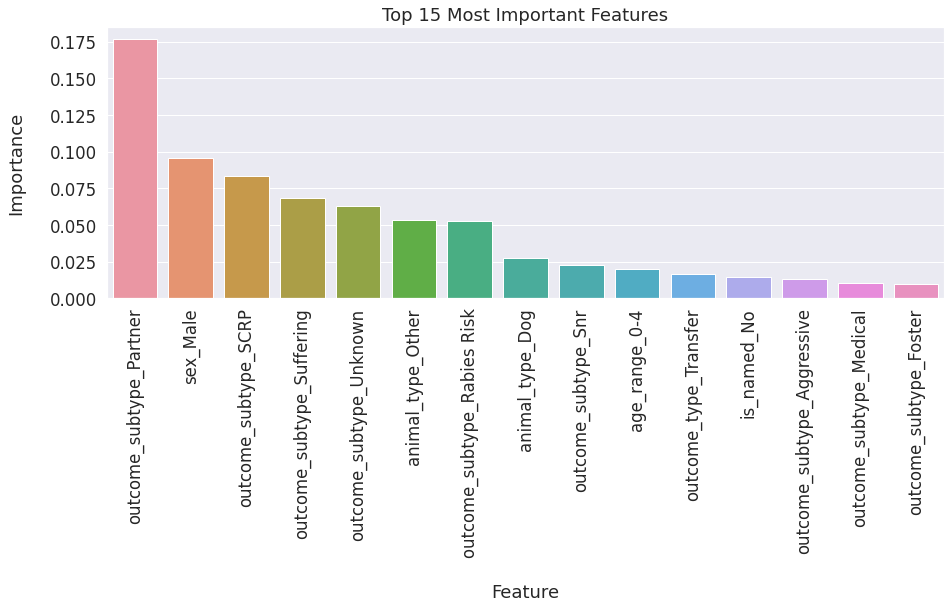

In [175]:
# Set seaborn font scale
sns.set(font_scale=1.50)

# Create a bar plot of top N most important features
plt.figure(figsize=(15, 5))
sns.barplot(x='feature', y='importance', data=importances_df)
plt.xticks(rotation=90)
plt.xlabel('Feature', labelpad=25)
plt.ylabel('Importance', labelpad=25)
plt.title(f'Top {top_n_features} Most Important Features')
plt.show()

<b>The XGB classifier identifies several key features crucial for predicting the outcome of an animal (<font color='#089ffc'>adoption, transfer, return to owner, or euthanasia</font>):</b>

* The most influential feature is the outcome subtype of the animal 'outcome_subtype_Partner', indicating that the animal was transfered to a partnering shelter.

* The sex of the animal, particularly if male ('sex_Male'), contributes to prediction.

* SCRP outcome subtype ('outcome_subtype_SCRP'), suffering outcome subtype ('outcome_subtype_suffering') and Unknown outcome subtype ('outcome_subtype_Unknown') all contribute to prediction.

* The classifier gives weight to the animal type, especially if it's one of the other animals, that aren't dogs or cats ('animal_type_Other').

* Outcome subtypes associated with rabies risk, often seen in other animals such as bats and raccoons ('outcome_subtype_Rabies Risk'), impact predictions.

* The classifier gives weight to the animal type, especially if it's a dog ('animal_type_Dog').

* SNR outcome subtype ('outcome_subtype_SNR') contributes to prediction.

* The classifier gives weight if to the age range of an animal, especially if the animal is 0-4 years old ('age_range_0-4').

* Transer outcome type ('outcome_type_Transfer') contributes to prediction.

* The classifier gives weight if an animal is named, especially if the animal is unnamed ('is_named_No').

* Outcome subtypes associated with aggression, often seen in dogs ('outcome_subtype_Aggressive'), impact predictions.

* Medical outcome subtype ('outcome_subtype_Medical') contributes to prediction.

* Outcome subtypes associated with fostering, often seen in cats ('outcome_subtype_Foster'), impact predictions.

In [176]:
def plot_shap(column_name):
    shap_values_outcome = shap_values[column_name]
    shap.summary_plot(shap_values_outcome, X, plot_type="bar", max_display=15, title=outcome_column)

<b>Column 'outcome_type_Adoption':</b>

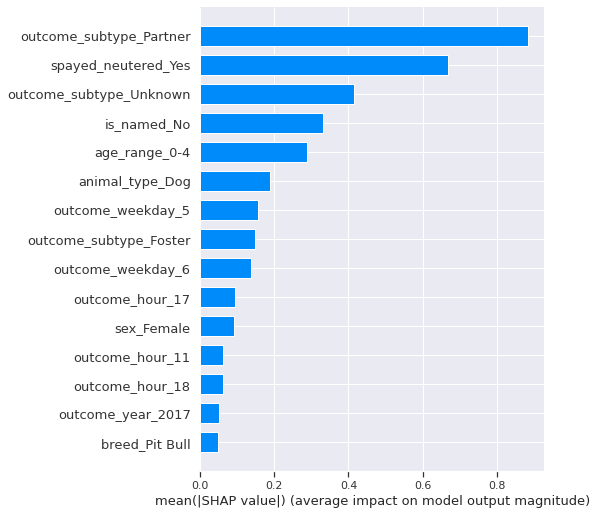

In [177]:
# Plot SHAP summary plot for 'outcome_type_Adoption' column
plot_shap(outcome_type_columns[0])

The most important features for predicting if an animal will be adopted are:
* 'outcome_subtype_Partner'.
* 'spayed_neutered_Yes' (people usually do prefer animals that are spayed/neutered).
* 'outcome_subtype_Unknown' (which is the most common outcome subtype because most animals don't have an outcome subtype).
* 'is_named_No' (usually, younger animals don't get a name because they won't spend a lot of time in the shelter before they'll get adopted).
* 'age_range_0-4' (people prefer adopting younger animals).
* 'animal_type_Dog' (more dogs are getting adopted).
* 'outcome_weekday_5' (meaning that people usually adopt animals on a friday).
* 'outcome_subtype_Foster' (many animals aren't really adopted, but sent to a fostering home until they do get adopted).
* 'outcome_hour_17' (and also 11 and 18 - hours when adoption usually occur).
* 'sex_Female' (more females get adopted than males).
* 'outcome_year_2017' (a year of peak in adopting).
* 'breed_Pit Bull' (breed of dogs who are most commonly adopted).

<b>Column 'outcome_type_Euthanasia':</b>

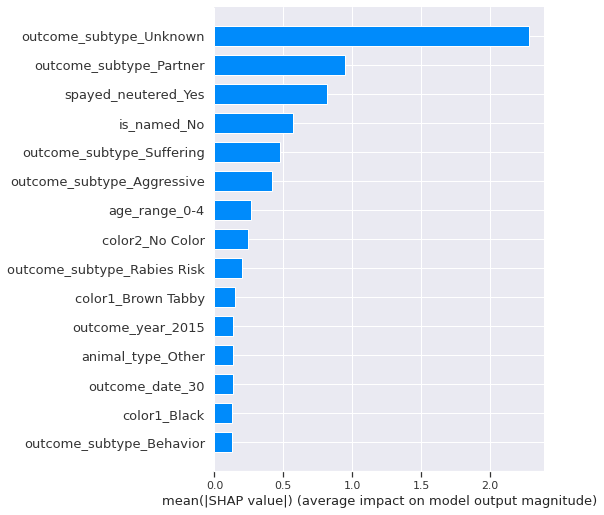

In [178]:
# Plot SHAP summary plot for 'outcome_type_Euthanasia' column
plot_shap(outcome_type_columns[1])

The most important features for predicting if an animal will be euthanized are:
* 'outcome_subtype_Unknown'.
* 'outcome_subtype_Partner'.
* 'spayed_neutered_Yes' (many of the animals who are wild animals, such as bats and raccoons, who get euthanized are listed as 'Unknown' for being spayed/neutered, but there is another main group of animals who get euthanized - pets. For instance, pets who are suffering from illnesses or aggressive pets, usually dogs).
* 'is_named_No' (for example, rabid bats).
* 'outcome_subtype_Suffering', 'outcome_subtype_Aggressive', 'outcome_subtype_Rabies Risk' and 'outcome_subtype_Behavior'.
* 'age_range_0-4'.

<b>Column 'outcome_type_Return to Owner':</b>

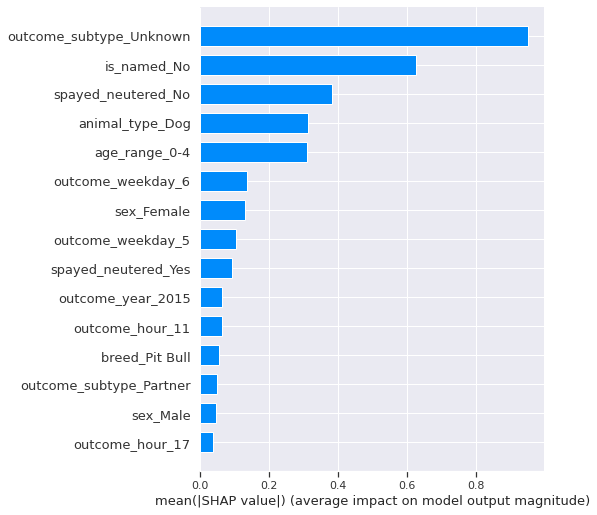

In [179]:
# Plot SHAP summary plot for 'outcome_type_Return to Owner' column
plot_shap(outcome_type_columns[2])

The most important features for predicting if an animal will be return to their owner are:
* 'outcome_subtype_Unknown'.
* 'is_named_No' (perhaps those are animals that were taken in the shelter as strays without a name, and had a chip).
* 'spayed_neutered_No'.
* 'animal_type_Dog' (more dogs are being returned to their owner).
* 'age_range_0-4' (younger animals return to their owner).

<b>Column 'outcome_type_Transfer':</b>

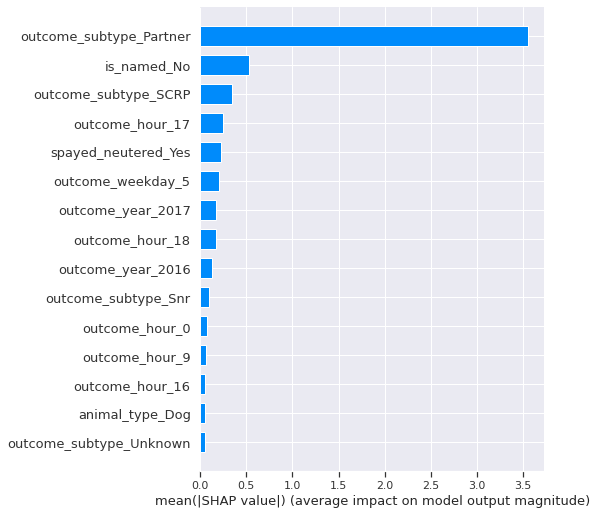

In [180]:
# Plot SHAP summary plot for 'outcome_type_Transfer' column
plot_shap(outcome_type_columns[3])

The most important features for predicting if an animal will be transfered are:
* 'outcome_subtype_Partner' (transfered to a partnering shelter).
* 'is_name_No'.

As mentioned before (when I was examining Correlations to the target feature at the 'Goodness Of Fit' section), it seems that features <font color='#012f85'><b>'mixed_breed_No'</b></font> and <font color='#012f85'><b>'mixed_breed_Yes'</b></font> are both not important features who predict the target features (<font color='#089ffc'><b>'outcome_type_Adoption/Euthanasia/Return to Owner/Transfer'</b></font>) - they don't appear in any SHAP summary plot of any of the target columns.

## <b>Better feature engineering</b>

In [181]:
new_df = df.copy()

### <b>Reducing the number of parameters</b>

#### <b>Outcome Type Distribution</b>

Counting the number of outcome subtype:

In [182]:
print_animal_count(new_df, 'outcome_subtype')

        outcome_subtype  count  percentage
14              Unknown  42081   52.866906
8               Partner  21057   26.454182
5                Foster   5832    7.326817
10                 SCRP   3160    3.969949
12            Suffering   2605    3.272695
9           Rabies Risk   2562    3.218674
11                  Snr    748    0.939722
0            Aggressive    639    0.802784
7               Offsite    364    0.457298
6               Medical    276    0.346742
3              Behavior    161    0.202266
1                At Vet     42    0.052765
4   Court/Investigation     40    0.050253
13             Underage     28    0.035177
2                  Barn      3    0.003769


The outcome subtypes ('Barn,' 'Underage,' 'Court/Investigation,' 'At Vet,' 'Behavior') were not among the top 15 most significant features and they appear in less than 0.5% of the instances. For this reason, I have decided to remove them:

In [183]:
new_df = new_df[(new_df['outcome_subtype'] != 'At Vet') & 
          (new_df['outcome_subtype'] != 'Underage') & 
          (new_df['outcome_subtype'] != 'Court/Investigation') &
          (new_df['outcome_subtype'] != 'Barn')]

#### <b>Color Distribution</b>

#### <b>Breed Distribution</b>

In [191]:
# Hyper Parameters
breed_counts = [50, 150, 10]

In [192]:
print(f"Number of different breeds in the 'breed' column: {len(new_df['breed'].value_counts())}")

Number of different breeds in the 'breed' column: 403


In [193]:
new_df = set_top_k_breeds(new_df, 'Cat', 'Other Cat Breed', breed_counts[0])
new_df = set_top_k_breeds(new_df, 'Dog', 'Other Dog Breed', breed_counts[1])
new_df = set_top_k_breeds(new_df, 'Other', 'Other Breed', breed_counts[2])

In [194]:
print(f"Number of different breeds in the 'breed' column: {len(new_df['breed'].value_counts())}")

Number of different breeds in the 'breed' column: 210


### <b>Removing Insignificant Columns</b>

In [195]:
# Removing 'mixed_breed' column from dataset
# (removing 'mixed_breed_No' and 'mixed_breed_Yes' from encoded datatset)
new_df.drop(columns=['mixed_breed'], inplace=True)

## <b>Improving ML Model</b>

### <b>Training the model and predicting</b>

In [196]:
# Dropping 'animal_id' column from the dataframe
dtf_model = new_df.drop('animal_id', axis=1)

# Converting all columns to the category data type
dtf_model = dtf_model.astype('category')

# Columns for one-hot encoding
columns_for_one_hot = ['age_range', 'animal_type', 'breed', 'color1', 'color2', 'outcome_year',
                    'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour',
                    'is_named', 'outcome_subtype', 'outcome_type', 'sex', 'spayed_neutered']

# One-hot encoding
encoded_data = pd.get_dummies(dtf_model, columns=columns_for_one_hot, prefix=columns_for_one_hot)

# Getting all the target columns (columns that include 'outcome_type' in their name)
outcome_type_columns = [col for col in encoded_data.columns if 'outcome_type' in col]

# Initialize StandardScaler object for feature scaling
scaler = StandardScaler()

# Initialize lists to store scores
validation_scores = []
test_scores = []

# Initialize an empty dictionaries to store feature importances and shap values
feature_importances = {}
shap_values = {}

#### <b>Run Model (~2-4 minutes):</b>

In [197]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]

    # Initialize the model
    model = XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=42)

    validation_scores, test_scores, model, feature_importances = fit_and_predict(outcome_column,
                            X, y, validation_scores, test_scores, model, feature_importances, scaler)
    
    # Explain model predictions using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values[outcome_column] = explainer.shap_values(X)

Column 'outcome_type_Adoption':
Validation scores:
Accuracy: 0.87193, Precision: 0.86881, Recall: 0.87535, F1-score: 0.87052

Test scores:
Accuracy: 0.87274, Precision: 0.86982, Recall: 0.87531, F1-score: 0.87141

Column 'outcome_type_Euthanasia':
Validation scores:
Accuracy: 0.99635, Precision: 0.98369, Recall: 0.99145, F1-score: 0.98753

Test scores:
Accuracy: 0.99648, Precision: 0.98478, Recall: 0.99115, F1-score: 0.98794

Column 'outcome_type_Return to Owner':
Validation scores:
Accuracy: 0.87507, Precision: 0.82395, Recall: 0.74437, F1-score: 0.77393

Test scores:
Accuracy: 0.87463, Precision: 0.81272, Recall: 0.74008, F1-score: 0.76776

Column 'outcome_type_Transfer':
Validation scores:
Accuracy: 0.98258, Precision: 0.97615, Recall: 0.98282, F1-score: 0.97939

Test scores:
Accuracy: 0.98069, Precision: 0.97419, Recall: 0.98057, F1-score: 0.97730



#### <b>Skip Model:</b>

In [199]:
print_model('skip improved model.txt')

Column 'outcome_type_Adoption':
Validation scores:
Accuracy: 0.87193, Precision: 0.86881, Recall: 0.87535, F1-score: 0.87052
Test scores:
Accuracy: 0.87274, Precision: 0.86982, Recall: 0.87531, F1-score: 0.87141
Column 'outcome_type_Euthanasia':
Validation scores:
Accuracy: 0.99635, Precision: 0.98369, Recall: 0.99145, F1-score: 0.98753
Test scores:
Accuracy: 0.99648, Precision: 0.98478, Recall: 0.99115, F1-score: 0.98794
Column 'outcome_type_Return to Owner':
Validation scores:
Accuracy: 0.87507, Precision: 0.82395, Recall: 0.74437, F1-score: 0.77393
Test scores:
Accuracy: 0.87463, Precision: 0.81272, Recall: 0.74008, F1-score: 0.76776
Column 'outcome_type_Transfer':
Validation scores:
Accuracy: 0.98258, Precision: 0.97615, Recall: 0.98282, F1-score: 0.97939
Test scores:
Accuracy: 0.98069, Precision: 0.97419, Recall: 0.98057, F1-score: 0.97730
--------------------------------------------------------------------------
Average Validation Scores:
Accuracy: 0.93148, Precision: 0.91315, Re

### <b>Evaluating the model</b>

In [198]:
# Calculate average validation accuracy, precision, recall and f1-score
print_average_score('Validation', calculate_average_score(validation_scores))

# Calculate average test accuracy, precision, recall and f1-score
print_average_score('Test', calculate_average_score(test_scores))

Average Validation Scores:
Accuracy: 0.93148
Precision: 0.91315
Recall: 0.89850
F1-score: 0.90284

Average Test Scores:
Accuracy: 0.93113
Precision: 0.91038
Recall: 0.89678
F1-score: 0.90110



In [200]:
# Define the number of top features to display
top_n_features = 15

# Calculate average feature importances across all outcome types
avg_feature_importances = np.mean([importances for importances in feature_importances.values()], axis=0)

# Sort and get the indices of top N most important features
top_feature_indices = avg_feature_importances.argsort()[-top_n_features:][::-1]

# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'importance': avg_feature_importances[top_feature_indices],
                               'feature': np.array(encoded_data.columns)[top_feature_indices]})

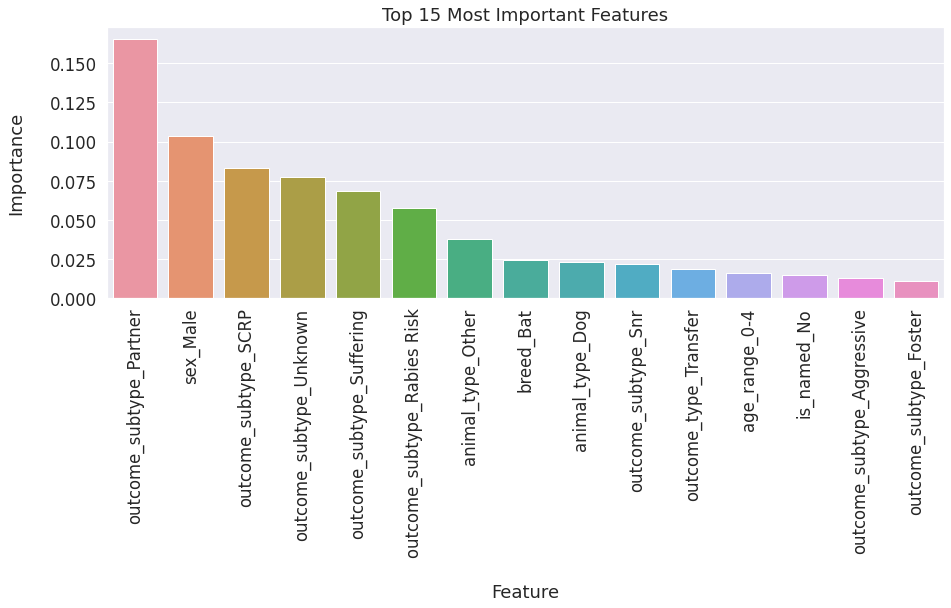

In [201]:
# Set seaborn font scale
sns.set(font_scale=1.50)

# Create a bar plot of top N most important features
plt.figure(figsize=(15, 5))
sns.barplot(x='feature', y='importance', data=importances_df)
plt.xticks(rotation=90)
plt.xlabel('Feature', labelpad=25)
plt.ylabel('Importance', labelpad=25)
plt.title(f'Top {top_n_features} Most Important Features')
plt.show()